In [1]:
import os
import numpy as np 
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow_hub as hub    
import tensorflow as tf
import Augmentor
from IPython.display import Image as Im
from IPython.display import display
%matplotlib inline

In [2]:
batch_size = 16
IMG_SHAPE = 299
base_dir = 'D:/Grad_Proj/endo_class'

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

device = '/gpu:0' if tf.config.list_physical_devices('GPU') else '/cpu:0'

In [3]:
training_data = tf.keras.utils.image_dataset_from_directory(directory = train_dir,
                                                           labels = 'inferred',
                                                           label_mode='binary',
                                                           batch_size=batch_size,
                                                           image_size=(IMG_SHAPE, IMG_SHAPE),
                                                           shuffle=True,
                                                           color_mode='rgb')

val_data = tf.keras.utils.image_dataset_from_directory(directory = val_dir,
                                                           labels = 'inferred',
                                                           label_mode='binary',
                                                           batch_size=batch_size,
                                                           image_size=(IMG_SHAPE, IMG_SHAPE),
                                                           color_mode='rgb')

test_data = tf.keras.utils.image_dataset_from_directory(directory = test_dir,
                                                           labels = 'inferred',
                                                           batch_size=batch_size,
                                                           image_size=(IMG_SHAPE, IMG_SHAPE),
                                                           color_mode='rgb')

Found 45510 files belonging to 2 classes.
Found 9488 files belonging to 2 classes.
Found 7357 files belonging to 2 classes.


In [4]:
@tf.function
def map_fn(img, label):
    image_height = IMG_SHAPE
    image_width = IMG_SHAPE
    img = tf.image.resize(img, [image_height, image_width])
    img /= 255
    return img, label

triann = training_data.map(map_fn)
vall = val_data.map(map_fn)
testt = test_data.map(map_fn)

In [6]:
IMAGE_RES = 299

URL = "https://tfhub.dev/google/imagenet/inception_v3/feature_vector/5"
feature_extractor = hub.KerasLayer(URL,
  input_shape=(IMAGE_RES, IMAGE_RES, 3),
  trainable=False)
with tf.device(device_name=device):
    
    model_inception3 = tf.keras.Sequential([
      feature_extractor,
      tf.keras.layers.Dense(2)
    ])

    model_inception3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 2048)              21802784  
                                                                 
 dense (Dense)               (None, 2)                 4098      
                                                                 
Total params: 21,806,882
Trainable params: 4,098
Non-trainable params: 21,802,784
_________________________________________________________________


In [7]:
with tf.device(device_name=device):
    
    model_inception3.compile(
      optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.0001),
      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      metrics=['accuracy'])

In [9]:
EPOCHS = 10
with tf.device(device_name=device):
    
    history = model_inception3.fit(triann,
                        epochs=EPOCHS,
                        validation_data=vall)

Epoch 1/10
2845/2845 [==============================] - 489s 172ms/step - loss: 0.0097 - accuracy: 0.9995 - val_loss: 0.0031 - val_accuracy: 0.9998
Epoch 2/10
2845/2845 [==============================] - 433s 152ms/step - loss: 0.0020 - accuracy: 0.9998 - val_loss: 0.0012 - val_accuracy: 0.9998
Epoch 3/10
2845/2845 [==============================] - 454s 159ms/step - loss: 8.1936e-04 - accuracy: 1.0000 - val_loss: 6.8741e-04 - val_accuracy: 0.9998
Epoch 4/10
2845/2845 [==============================] - 447s 157ms/step - loss: 4.1498e-04 - accuracy: 1.0000 - val_loss: 4.7283e-04 - val_accuracy: 0.9998
Epoch 5/10
2845/2845 [==============================] - 453s 159ms/step - loss: 2.3876e-04 - accuracy: 1.0000 - val_loss: 3.4374e-04 - val_accuracy: 0.9998
Epoch 6/10
2845/2845 [==============================] - 455s 160ms/step - loss: 1.4318e-04 - accuracy: 1.0000 - val_loss: 2.6844e-04 - val_accuracy: 0.9999
Epoch 7/10
2845/2845 [==============================] - 452s 159ms/step - loss: 

In [10]:
loss, accuracy_d = model_inception3.evaluate(testt, verbose=2)
print(" model, accuracy: {:5.2f}%".format(100 * accuracy_d))

460/460 - 63s - loss: 7.7740e-04 - accuracy: 0.9999 - 63s/epoch - 137ms/step
 model, accuracy: 99.99%


In [11]:
model_inception3.save('D:/Grad_Proj/endo_class/endo_model_class.h5')

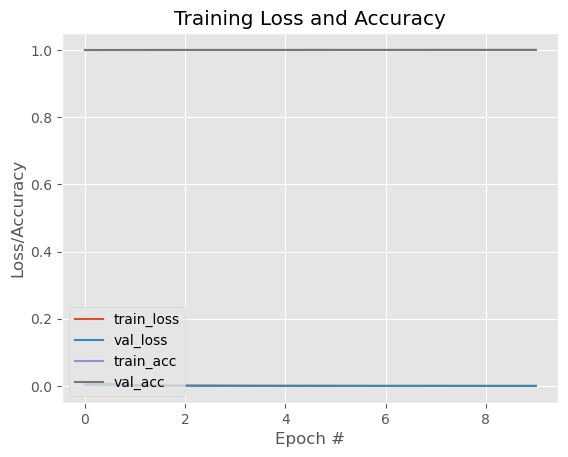

In [17]:
plt.style.use("ggplot")
plt.figure()
N = 10
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("D:/Grad_Proj/endo_class/mygraph.png")